In [1]:
# package imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 

C:\Users\dnhor\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
gss = pd.read_csv('Data/gss18.csv', low_memory=False)

In [3]:
interesting_variables = ['LONELY2', 'SATJOB', 'MOREDAYS', 'WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'AGE','INTCNTCT']
# testing ridding of s
# GSS rid of HOMPOP, will HOUSEHOLD SIZE use from AARP
gss = gss[interesting_variables]

## Preprocessing

In [4]:
# how many nulls?
# Loop through each column
# and check the amount of nulls.
# Only print if there are more than 0.

for col in gss.columns:
    if gss[col].isnull().sum() > 0:
        print(f'{round(gss[col].isnull().sum()/gss.shape[0],3)}%\t{gss[col].isnull().sum()} null values in {col}')

0.503%	1182 null values in LONELY2
0.259%	609 null values in SATJOB
0.403%	947 null values in MOREDAYS
0.396%	930 null values in WRKHOME
0.008%	19 null values in HLTHPHYS
0.008%	19 null values in HLTHMNTL
0.503%	1180 null values in CONWKDAY
0.503%	1182 null values in PARTLSC
0.003%	7 null values in AGE
0.502%	1179 null values in INTCNTCT


In [5]:
# recode social isolation
gss['is_si'] = gss['LONELY2'].apply(lambda x: 1 if (x == 3 or x == 4 or x == 5) else 0)

In [6]:
# bin wkdays
bins = [-1,0,7,14,21,31]#pd.IntervalIndex.from_tuples([(-1,1), (1, 7), (7, 14), (14, 21),(21,30)])


gss['MOREWEEKS'] = pd.cut(gss['MOREDAYS'],bins,labels=['0','1','2','3','4'])

In [7]:
bins = [18,29,44,59,89]#,pd.IntervaIndex.from_tuples([(18, 29), (30, 44), (45, 59),(60,89)])


gss['Age Group'] = pd.cut(gss['AGE'],bins,labels=[1,2,3,4])

####### Age group ########

In [8]:
#bins= [0,11,12,15,21]
#gss['EDUC'] = pd.cut(gss['EDUC'],bins,labels=[1,2,3,4])#labels=['No HS Diploma','HS Graduate','Some College','BA or Above'])
######## EDUCATION ######

## Decision Tree

In [9]:
clf = DecisionTreeClassifier(random_state=0)

In [10]:
gss = gss.dropna()
for colm in gss.columns:
    print(f'{colm}: \t{gss[colm].unique()}')

LONELY2: 	[2. 3. 1. 4. 5.]
SATJOB: 	[1. 2. 3. 4.]
MOREDAYS: 	[ 2.  1. 24.  3.  6.  0. 15. 30. 20. 12. 18.  5.  4. 10. 26. 25.  8. 28.
  7. 17. 22. 14. 23.  9. 16.]
WRKHOME: 	[1. 4. 5. 6. 2. 3.]
HLTHPHYS: 	[1. 3. 2. 4. 5.]
HLTHMNTL: 	[1. 2. 3. 4. 5.]
CONWKDAY: 	[4. 3. 2. 6. 1. 5.]
PARTLSC: 	[3. 2. 5. 1. 4.]
AGE: 	[63. 59. 43. 55. 34. 44. 40. 30. 20. 65. 46. 22. 23. 28. 37. 42. 21. 70.
 53. 29. 50. 56. 67. 54. 48. 76. 39. 69. 60. 35. 38. 26. 57. 19. 36. 61.
 33. 51. 58. 45. 52. 25. 27. 24. 77. 47. 74. 32. 31. 72. 66. 68. 49. 64.
 41. 71. 78. 75. 85. 73. 62. 89.]
INTCNTCT: 	[2. 3. 1. 4. 5.]
is_si: 	[0 1]
MOREWEEKS: 	['1', '4', '0', '3', '2']
Categories (5, object): ['0' < '1' < '2' < '3' < '4']
Age Group: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]


### make x and y

In [11]:
x = gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss['is_si']
x.shape

(689, 9)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)#,stratify=x['MOREWEEKS'])

In [13]:
# decision tree regular fit
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.7105263157894737

In [14]:
# baseline
gss['is_si'].value_counts()[0]/gss['is_si'].value_counts().sum()
# 79% baseline. awkward.

0.7561683599419449

In [15]:
# 79%... what quantities?
gss['is_si'].value_counts()

0    521
1    168
Name: is_si, dtype: int64

In [16]:
# prepare grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [17]:
# do the grid search
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [18]:
CV_DT.score(x_test, y_test)

0.7543859649122807

In [19]:
x.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,INTCNTCT,MOREWEEKS,Age Group
3,1.0,1.0,1.0,1.0,4.0,3.0,2.0,1,4
6,1.0,1.0,3.0,2.0,3.0,2.0,3.0,1,3
7,1.0,1.0,2.0,3.0,4.0,5.0,2.0,4,2
9,2.0,1.0,2.0,3.0,4.0,1.0,2.0,1,3
11,2.0,1.0,3.0,3.0,2.0,1.0,1.0,1,2


## upsampling is_si

In [20]:
to_resample = gss.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_rebal = pd.concat([gss, our_resample])

In [21]:
x = gss_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss_rebal['is_si']
x.shape

(1085, 9)

In [22]:
gss_rebal['is_si'].value_counts()

1    564
0    521
Name: is_si, dtype: int64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [24]:
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.807799442896936

In [25]:
param_grid = { 
#     'max_leaf_nodes': range(2,1000,22),
#     'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
#     'max_depth' : range(1,100, 5), # again, steps of 25
#     'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [26]:
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None]})

In [27]:
CV_DT.score(x_test, y_test)

0.8161559888579387

In [28]:
x.shape

(1085, 9)

In [29]:
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

0.047	SATJOB
0.106	WRKHOME
0.119	HLTHPHYS
0.183	HLTHMNTL
0.093	CONWKDAY
0.124	PARTLSC
0.126	INTCNTCT
0.115	MOREWEEKS
0.087	Age Group


In [30]:
# DT for each age category
for ages in gss['Age Group'].unique():
    print(f'---------- ages {ages}-----------')
    age_gss = gss_rebal.loc[gss_rebal['Age Group'] == ages]
    x = age_gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y = age_gss['is_si']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf.fit(x_train,y_train)
    print(f'{round(clf.score(x_test, y_test),3)}% {ages}')
    
    for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')

---------- ages 4-----------
0.824% 4
0.153	SATJOB
0.0	WRKHOME
0.029	HLTHPHYS
0.335	HLTHMNTL
0.0	CONWKDAY
0.083	PARTLSC
0.22	INTCNTCT
0.18	MOREWEEKS
0.0	Age Group
---------- ages 3-----------
0.783% 3
0.039	SATJOB
0.075	WRKHOME
0.203	HLTHPHYS
0.356	HLTHMNTL
0.1	CONWKDAY
0.123	PARTLSC
0.057	INTCNTCT
0.047	MOREWEEKS
0.0	Age Group
---------- ages 2-----------
0.841% 2
0.067	SATJOB
0.137	WRKHOME
0.141	HLTHPHYS
0.124	HLTHMNTL
0.126	CONWKDAY
0.167	PARTLSC
0.12	INTCNTCT
0.117	MOREWEEKS
0.0	Age Group
---------- ages 1-----------
0.844% 1
0.113	SATJOB
0.017	WRKHOME
0.157	HLTHPHYS
0.129	HLTHMNTL
0.2	CONWKDAY
0.179	PARTLSC
0.086	INTCNTCT
0.119	MOREWEEKS
0.0	Age Group


[]

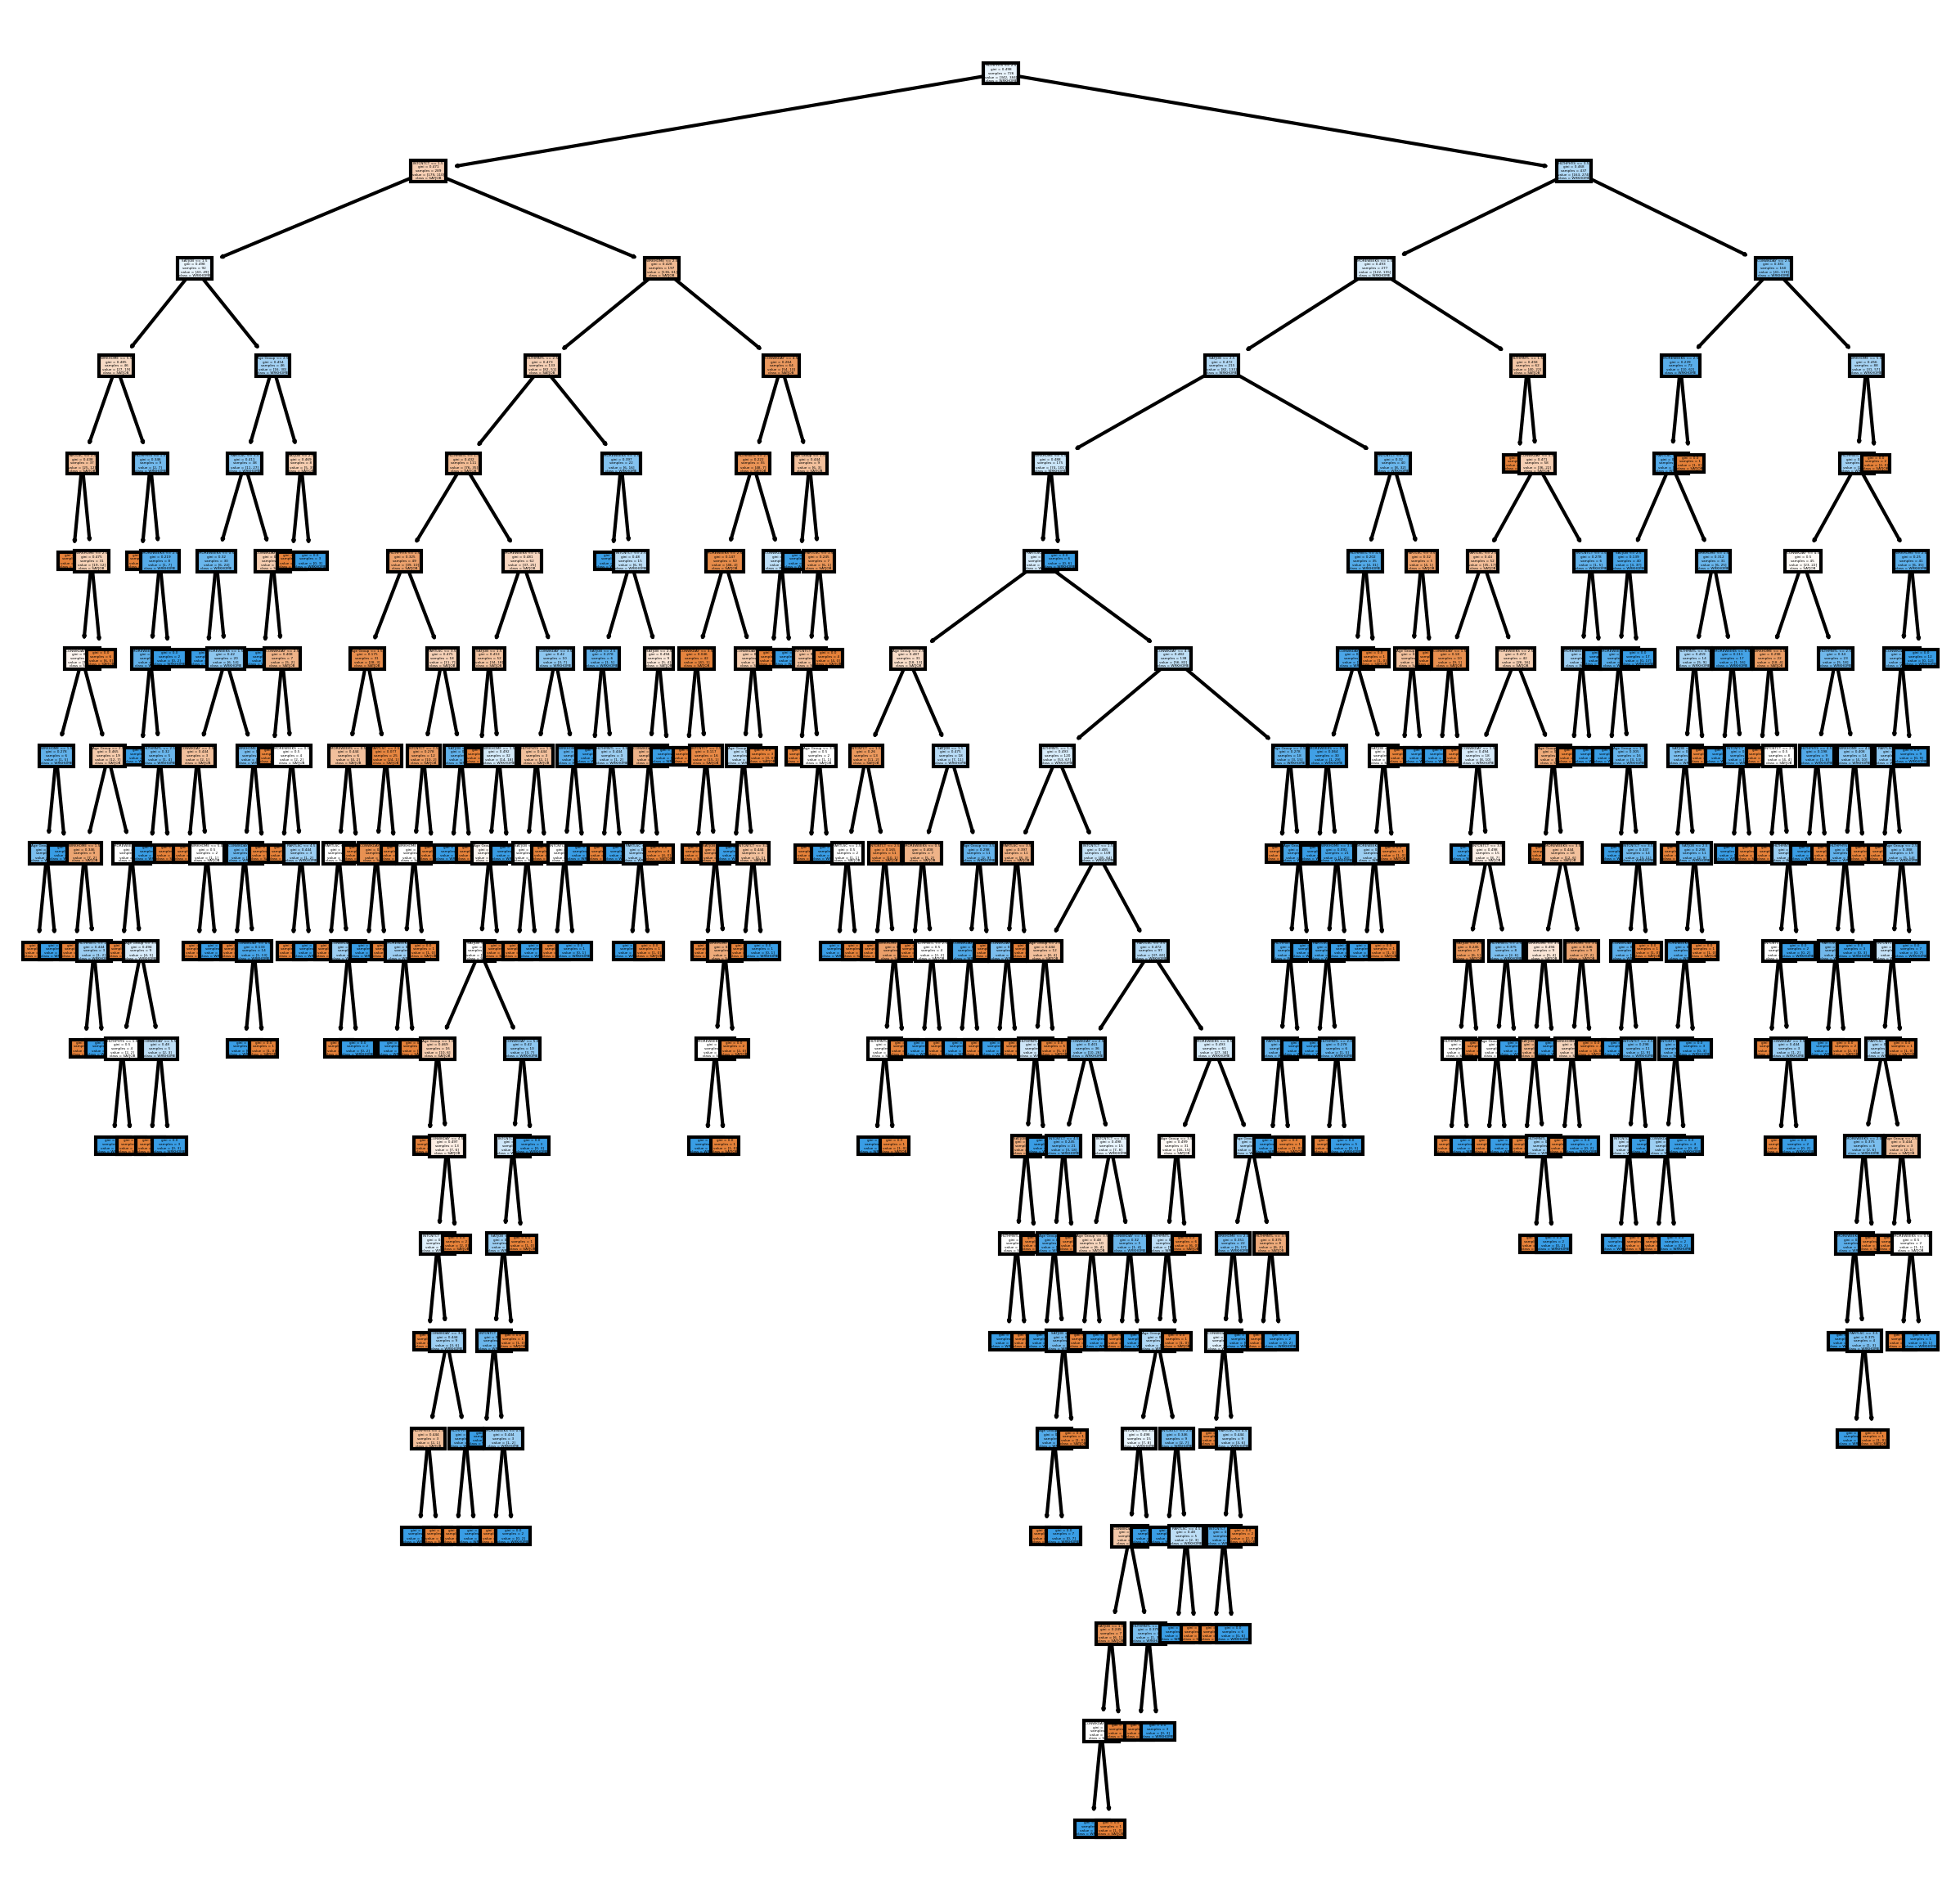

In [31]:
fix, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(CV_DT.best_estimator_, feature_names = x.columns, class_names = CV_DT.feature_names_in_, filled = True)
plt.plot()

In [32]:
# upsample training data only CHECK
# fix tree????
# trim down unncessary vars?
# make output legible CHECK
# seperate modeling from data manip, gss and aarp 
# linear 

## Upsampling only training data

In [33]:
# make train and test set
gss_train, gss_test = train_test_split(gss, test_size=0.33, random_state=42)

In [34]:
# upsample train set
to_resample = gss_train.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_train_rebal = pd.concat([gss_train, our_resample])

In [35]:
# manually create x,y test and trains
x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y_train = gss_train_rebal['is_si']
y_test = gss_test['is_si']

In [36]:
# grid search it yeah
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None]})

In [37]:
CV_DT.score(x_test, y_test)

0.7280701754385965

In [38]:
y_test.value_counts()

0    172
1     56
Name: is_si, dtype: int64

In [39]:
#Making dataframe for feature importances
fi_dfoverall = pd.DataFrame()

#Getting Feature importances for the overall model ----------------Matt Check that this is right-----------------
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

    fi_new = {'importance': (round(importance,3)), 'feature': feature}
    fi_dfoverall = pd.concat([fi_dfoverall, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)

0.113	SATJOB
0.017	WRKHOME
0.157	HLTHPHYS
0.129	HLTHMNTL
0.2	CONWKDAY
0.179	PARTLSC
0.086	INTCNTCT
0.119	MOREWEEKS
0.0	Age Group


In [40]:
#Creating dataframes to hold feature importances
fi_df1 = pd.DataFrame()
fi_df2 = pd.DataFrame()
fi_df3 = pd.DataFrame()
fi_df4 = pd.DataFrame()
summary_plot = pd.DataFrame()

In [41]:
from imblearn.over_sampling import SMOTEN
# DT for each age category
for ages in gss['Age Group'].unique():
    #print(f'---------- ages {ages} -----------')
    
    # grab gss for single age group
    aged_gss = gss.loc[gss['Age Group'] == ages]
    
    # split into train and test
    gss_train, gss_test = train_test_split(aged_gss, test_size=0.33, random_state=42)
    # upsample train set
    
    sm = SMOTEN(random_state=42)
    
    # manually create x,y test and trains
    x_train = gss_train.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si', 'Age Group'], axis=1)
    x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si', 'Age Group'], axis=1)
    y_train = gss_train['is_si']
    y_test = gss_test['is_si']
    
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    # new decision tree
    clf = DecisionTreeClassifier(random_state=42)
    
    # grid to search
    param_grid = { 
#     'max_leaf_nodes': range(2,1000,11),
#     'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
#     'max_depth' : range(1,100, 3),
#     'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}
    # new grid search using decision tree and grid from above
    CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 4, n_jobs=-1) 
    
    # let's 'train'
    CV_DT.fit(x_train, y_train)
    
    # print the results
    print(f'---------- score for age {ages}: {round(CV_DT.score(x_test, y_test),3)}% ----------')

    
    for importance, feature in zip(CV_DT.best_estimator_.feature_importances_, CV_DT.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')
        
        #Saving summary data to a dataframe for plots
        if ages ==1:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df1 = pd.concat([fi_df1, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)

        if ages==2:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df2 = pd.concat([fi_df2, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)
            
        if ages==3:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df3 = pd.concat([fi_df3, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)

        if ages==4:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df4 = pd.concat([fi_df4, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)
    ###### print train and test set sizes
    print(f'training set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 


---------- score for age 4: 0.758% ----------
0.0	SATJOB
0.075	WRKHOME
0.054	HLTHPHYS
0.316	HLTHMNTL
0.134	CONWKDAY
0.044	PARTLSC
0.265	INTCNTCT
0.111	MOREWEEKS
training set size: 
1    49
0    49
Name: is_si, dtype: int64
testing set size:  
0    28
1     5
Name: is_si, dtype: int64
---------- score for age 3: 0.623% ----------
0.038	SATJOB
0.174	WRKHOME
0.146	HLTHPHYS
0.17	HLTHMNTL
0.155	CONWKDAY
0.146	PARTLSC
0.098	INTCNTCT
0.073	MOREWEEKS
training set size: 
0    109
1    109
Name: is_si, dtype: int64
testing set size:  
0    50
1    19
Name: is_si, dtype: int64
---------- score for age 2: 0.655% ----------
0.105	SATJOB
0.076	WRKHOME
0.103	HLTHPHYS
0.143	HLTHMNTL
0.157	CONWKDAY
0.134	PARTLSC
0.145	INTCNTCT
0.136	MOREWEEKS
training set size: 
0    127
1    127
Name: is_si, dtype: int64
testing set size:  
0    68
1    16
Name: is_si, dtype: int64
---------- score for age 1: 0.636% ----------
0.067	SATJOB
0.022	WRKHOME
0.137	HLTHPHYS
0.202	HLTHMNTL
0.208	CONWKDAY
0.093	PARTLSC
0.196	

In [42]:
#Add a new column in each summary dataframe that indicates the Age group of the dataframe
fi_df1['Age Group'] = '18-29'
fi_df2['Age Group'] = '30-44'
fi_df3['Age Group'] = '45-59'
fi_df4['Age Group'] = '60+'
fi_dfoverall['Age Group'] = 'Overall'

#Create a new data frame to hold data that will be used for plotting
summary_plot = pd.concat([fi_df1,fi_df2,fi_df3,fi_df4,fi_dfoverall])

In [46]:
summary_plot.replace(to_replace={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home',
                         'EDUC': 'Education',
                            'INTCNTCT': 'Electronic Communications'},inplace=True)

Text(0, 0.5, '')

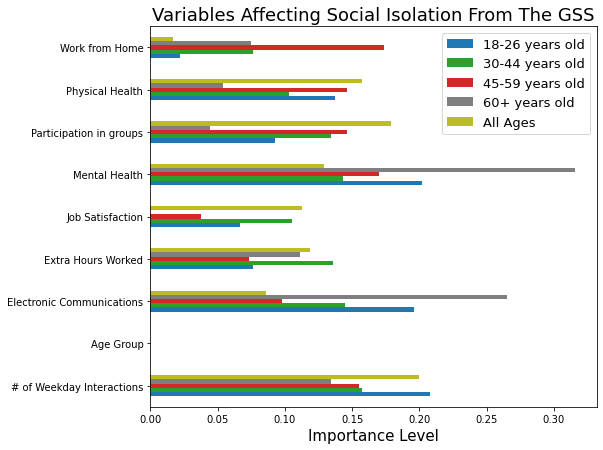

In [47]:
#plt.figure(figsize=(10,10))
ax = summary_plot.pivot(columns='Age Group', index='feature').plot.barh(figsize=(8,7),rot=0,color=['tab:blue','tab:green','tab:red','tab:gray','tab:olive'])#


plt.title('Variables Affecting Social Isolation From The GSS', fontsize=18)
plt.xlabel('Importance Level',fontsize=15)
plt.legend(labels=['18-26 years old','30-44 years old','45-59 years old','60+ years old','All Ages'],fontsize=13)
plt.ylabel('',fontsize=17)
#ax.tick_params(axis='x',labelsize=12)
#ax.tick_params(axis='y', labelsize=10)
# ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Married','Participation in Groups','Job Satisfaction','Work From Home'])
#plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )

In [48]:
summary_plot.pivot(index='feature',columns='Age Group')

importance                             
Age Group                      18-29  30-44  45-59    60+ Overall
feature                                                          
# of Weekday Interactions      0.208  0.157  0.155  0.134   0.200
Age Group                        NaN    NaN    NaN    NaN   0.000
Electronic Communications      0.196  0.145  0.098  0.265   0.086
Extra Hours Worked             0.076  0.136  0.073  0.111   0.119
Job Satisfaction               0.067  0.105  0.038  0.000   0.113
Mental Health                  0.202  0.143  0.170  0.316   0.129
Participation in groups        0.093  0.134  0.146  0.044   0.179
Physical Health                0.137  0.103  0.146  0.054   0.157
Work from Home                 0.022  0.076  0.174  0.075   0.017